In [1]:
# ! module load mambaforge
# ! mamba create -n wind_forecasting_env python=3.12
# ! mamba activate wind_forecasting_env
# ! conda install -c conda-forge jupyterlab mpi4py impi_rt
# ! pip install ./OpenOA # have to change pyproject.toml to allow for python 3.12.7
# ! pip install floris polars windrose netCDF4 statsmodels h5pyd seaborn pyarrow

from data_loader import DataLoader
from data_filter import DataFilter
from data_inspector import DataInspector
from openoa.utils import qa, plot, filters, power_curve
import polars.selectors as cs
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sys import platform
import os

  _exp = _sv(version)



## Print NetCDF Data Structure, Load Data, Transform Datetime Columns

In [2]:
if platform == "darwin":
    DATA_DIR = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data"
    PL_SAVE_PATH = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/data/kp.turbine.zo2.b0.raw.csv"
    FILE_SIGNATURE = "kp.turbine.z02.b0.20220301.*.wt073.nc"
    MULTIPROCESSOR = None
    turbine_input_filepath = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/inputs/ge_282_127.yaml"
    farm_input_filepath = "/Users/ahenry/Documents/toolboxes/wind_forecasting/examples/inputs/gch_KP_v4.yaml"
elif platform == "linux":
    DATA_DIR = "/pl/active/paolab/awaken_data/kp.turbine.z02.b0/"
    PL_SAVE_PATH = "/scratch/alpine/aohe7145/awaken_data/short_kp.turbine.zo2.b0.raw.csv"
    FILE_SIGNATURE = "kp.turbine.z02.b0.20220301.*.*.nc"
    MULTIPROCESSOR = "cf"
    turbine_input_filepath = "/projects/aohe7145/toolboxes/wind-forecasting/examples/inputs/ge_282_127.yaml"
    farm_input_filepath = "/projects/aohe7145/toolboxes/wind-forecasting/examples/inputs/gch_KP_v4.yaml"

data_loader = DataLoader(data_dir=DATA_DIR, file_signature=FILE_SIGNATURE, multiprocessor=MULTIPROCESSOR, 
                         features=["turbine_id", "time", "turbine_status", "wind_direction", "wind_speed", "power_output", "nacelle_direction"])

In [3]:
data_loader.print_netcdf_structure(data_loader.file_paths[0])

NetCDF File: kp.turbine.z02.b0.20220301.000000.wt085.nc

Global Attributes:

Dimensions:
  date: 247362
  string7: 7

Variables:
  Flag:
    Dimensions: ('date', 'string7')
    Shape: (247362, 7)
    Data type: |S1
    Attributes:
      _Encoding: utf-8
  date:
    Dimensions: ('date',)
    Shape: (247362,)
    Data type: int32
    Attributes:
      units: milliseconds since 2022-03-01 00:00:00.061000
      calendar: proleptic_gregorian
  WCNV.GnA1:
    Dimensions: ('date',)
    Shape: (247362,)
    Data type: float64
    Attributes:
      _FillValue: nan
  WCNV.GnA2:
    Dimensions: ('date',)
    Shape: (247362,)
    Data type: float64
    Attributes:
      _FillValue: nan
  WCNV.GnA3:
    Dimensions: ('date',)
    Shape: (247362,)
    Data type: float64
    Attributes:
      _FillValue: nan
  WCNV.GnPNV1:
    Dimensions: ('date',)
    Shape: (247362,)
    Data type: float64
    Attributes:
      _FillValue: nan
  WCNV.GnPNV2:
    Dimensions: ('date',)
    Shape: (247362,)
    Data ty

In [4]:
if os.path.exists(PL_SAVE_PATH) and True:
    # Note that the order of the columns in the provided schema must match the order of the columns in the CSV being read.
    schema = pl.Schema({"turbine_id": pl.String(),
                        "time": pl.Datetime(time_unit="ms"),
                        "turbine_status": pl.Float64,
                        "wind_direction": pl.Float64,
                        "wind_speed": pl.Float64,
                        "power_output": pl.Float64,
                        "nacelle_direction": pl.Float64,
                       })
    
    df = pl.read_csv(PL_SAVE_PATH, schema=schema)
else:
    df = data_loader.read_multi_netcdf()
    df.write_csv(PL_SAVE_PATH)

df

shape: (4_014_874, 7)
┌────────────┬──────────────┬──────────────┬──────────────┬────────────┬─────────────┬─────────────┐
│ turbine_id ┆ time         ┆ turbine_stat ┆ wind_directi ┆ wind_speed ┆ power_outpu ┆ nacelle_dir │
│ ---        ┆ ---          ┆ us           ┆ on           ┆ ---        ┆ t           ┆ ection      │
│ str        ┆ datetime[ms] ┆ ---          ┆ ---          ┆ f64        ┆ ---         ┆ ---         │
│            ┆              ┆ f64          ┆ f64          ┆            ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪══════════════╪════════════╪═════════════╪═════════════╡
│ wt001      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 6.137497   ┆ 990.080261  ┆ null        │
│            ┆ 00:00:01.499 ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 6.739313   ┆ 998.767334  ┆ null        │
│            ┆ 00:00:04.499 ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 220.0        ┆ null       ┆ null        ┆ null        │
│            ┆ 00:00:04.983 ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ null         ┆ null       ┆ null        ┆ null        │
│            ┆ 00:00:08.499 ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 210.0        ┆ null       ┆ null        ┆ null        │
│            ┆ 00:00:10.046 ┆              ┆              ┆            ┆             ┆             │
│ …          ┆ …            ┆ …            ┆ …            ┆ …          ┆ …           ┆ …           │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ null         ┆ null       ┆ null        ┆ null        │
│            ┆ 23:59:53.499 ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 5.294231   ┆ 381.0566    ┆ null        │
│            ┆ 23:59:55.499 ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ null         ┆ null       ┆ null        ┆ null        │
│            ┆ 23:59:56.499 ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 195.0        ┆ null       ┆ null        ┆ null        │
│            ┆ 23:59:56.896 ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 5.436787   ┆ 386.884247  ┆ null        │
│            ┆ 23:59:58.499 ┆              ┆              ┆            ┆             ┆             │
└────────────┴──────────────┴──────────────┴──────────────┴────────────┴─────────────┴─────────────┘

In [5]:
df = data_loader.reduce_features(df)
df

shape: (2_984_333, 7)
┌────────────┬──────────────┬──────────────┬──────────────┬────────────┬─────────────┬─────────────┐
│ turbine_id ┆ time         ┆ turbine_stat ┆ wind_directi ┆ wind_speed ┆ power_outpu ┆ nacelle_dir │
│ ---        ┆ ---          ┆ us           ┆ on           ┆ ---        ┆ t           ┆ ection      │
│ str        ┆ datetime[ms] ┆ ---          ┆ ---          ┆ f64        ┆ ---         ┆ ---         │
│            ┆              ┆ f64          ┆ f64          ┆            ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪══════════════╪════════════╪═════════════╪═════════════╡
│ wt001      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 6.137497   ┆ 990.080261  ┆ null        │
│            ┆ 00:00:01.499 ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 6.739313   ┆ 998.767334  ┆ null        │
│            ┆ 00:00:04.499 ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 220.0        ┆ null       ┆ null        ┆ null        │
│            ┆ 00:00:04.983 ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 210.0        ┆ null       ┆ null        ┆ null        │
│            ┆ 00:00:10.046 ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 7.301422   ┆ 989.993958  ┆ null        │
│            ┆ 00:00:14.499 ┆              ┆              ┆            ┆             ┆             │
│ …          ┆ …            ┆ …            ┆ …            ┆ …          ┆ …           ┆ …           │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 5.675796   ┆ 403.063629  ┆ null        │
│            ┆ 23:59:49.499 ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 200.0        ┆ null       ┆ null        ┆ null        │
│            ┆ 23:59:51.880 ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 5.294231   ┆ 381.0566    ┆ null        │
│            ┆ 23:59:55.499 ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 195.0        ┆ null       ┆ null        ┆ null        │
│            ┆ 23:59:56.896 ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 5.436787   ┆ 386.884247  ┆ null        │
│            ┆ 23:59:58.499 ┆              ┆              ┆            ┆             ┆             │
└────────────┴──────────────┴──────────────┴──────────────┴────────────┴─────────────┴─────────────┘

In [6]:
data_filter = DataFilter(turbine_availability_col=None, turbine_status_col="turbine_status")

In [7]:
df = data_filter.resample(df, dt=5)
df

shape: (1_489_656, 7)
┌────────────┬──────────────┬──────────────┬──────────────┬────────────┬─────────────┬─────────────┐
│ turbine_id ┆ time         ┆ turbine_stat ┆ wind_directi ┆ wind_speed ┆ power_outpu ┆ nacelle_dir │
│ ---        ┆ ---          ┆ us           ┆ on           ┆ ---        ┆ t           ┆ ection      │
│ str        ┆ datetime[ms] ┆ ---          ┆ ---          ┆ f64        ┆ ---         ┆ ---         │
│            ┆              ┆ f64          ┆ f64          ┆            ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪══════════════╪════════════╪═════════════╪═════════════╡
│ wt001      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 6.137497   ┆ 990.080261  ┆ null        │
│            ┆ 00:00:00     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 220.0        ┆ 6.739313   ┆ 998.767334  ┆ null        │
│            ┆ 00:00:05     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 210.0        ┆ null       ┆ null        ┆ null        │
│            ┆ 00:00:10     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 214.0        ┆ 7.301422   ┆ 989.993958  ┆ null        │
│            ┆ 00:00:15     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 219.0        ┆ 6.638575   ┆ 999.7942    ┆ null        │
│            ┆ 00:00:20     ┆              ┆              ┆            ┆             ┆             │
│ …          ┆ …            ┆ …            ┆ …            ┆ …          ┆ …           ┆ …           │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 194.0        ┆ 5.239842   ┆ 402.2117    ┆ null        │
│            ┆ 23:59:40     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 199.0        ┆ null       ┆ null        ┆ null        │
│            ┆ 23:59:45     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 200.0        ┆ 5.675796   ┆ 403.063629  ┆ null        │
│            ┆ 23:59:50     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 195.0        ┆ 5.294231   ┆ 381.0566    ┆ null        │
│            ┆ 23:59:55     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-02   ┆ null         ┆ null         ┆ 5.436787   ┆ 386.884247  ┆ null        │
│            ┆ 00:00:00     ┆              ┆              ┆            ┆             ┆             │
└────────────┴──────────────┴──────────────┴──────────────┴────────────┴─────────────┴─────────────┘

## Remove Inoperational Turbine Rows, Interpolate Null Data

In [8]:
df = data_filter.filter_inoperational(df, status_codes=[1], include_nan=True)
df

shape: (1_488_372, 7)
┌────────────┬──────────────┬──────────────┬──────────────┬────────────┬─────────────┬─────────────┐
│ turbine_id ┆ time         ┆ turbine_stat ┆ wind_directi ┆ wind_speed ┆ power_outpu ┆ nacelle_dir │
│ ---        ┆ ---          ┆ us           ┆ on           ┆ ---        ┆ t           ┆ ection      │
│ str        ┆ datetime[ms] ┆ ---          ┆ ---          ┆ f64        ┆ ---         ┆ ---         │
│            ┆              ┆ f64          ┆ f64          ┆            ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪══════════════╪════════════╪═════════════╪═════════════╡
│ wt001      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 6.137497   ┆ 990.080261  ┆ null        │
│            ┆ 00:00:00     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 220.0        ┆ 6.739313   ┆ 998.767334  ┆ null        │
│            ┆ 00:00:05     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 210.0        ┆ null       ┆ null        ┆ null        │
│            ┆ 00:00:10     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 214.0        ┆ 7.301422   ┆ 989.993958  ┆ null        │
│            ┆ 00:00:15     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 219.0        ┆ 6.638575   ┆ 999.7942    ┆ null        │
│            ┆ 00:00:20     ┆              ┆              ┆            ┆             ┆             │
│ …          ┆ …            ┆ …            ┆ …            ┆ …          ┆ …           ┆ …           │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 194.0        ┆ 5.239842   ┆ 402.2117    ┆ null        │
│            ┆ 23:59:40     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 199.0        ┆ null       ┆ null        ┆ null        │
│            ┆ 23:59:45     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 200.0        ┆ 5.675796   ┆ 403.063629  ┆ null        │
│            ┆ 23:59:50     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 195.0        ┆ 5.294231   ┆ 381.0566    ┆ null        │
│            ┆ 23:59:55     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-02   ┆ null         ┆ null         ┆ 5.436787   ┆ 386.884247  ┆ null        │
│            ┆ 00:00:00     ┆              ┆              ┆            ┆             ┆             │
└────────────┴──────────────┴──────────────┴──────────────┴────────────┴─────────────┴─────────────┘

In [9]:
#df = data_filter.resolve_missing_data(df, features=["wind_speed", "wind_direction", "power_output", "nacelle_direction"], how="forward_fill")
#df

## Plot Wind Farm, Data Distributions

In [10]:
data_inspector = DataInspector(turbine_input_filepath=turbine_input_filepath, farm_input_filepath=farm_input_filepath)

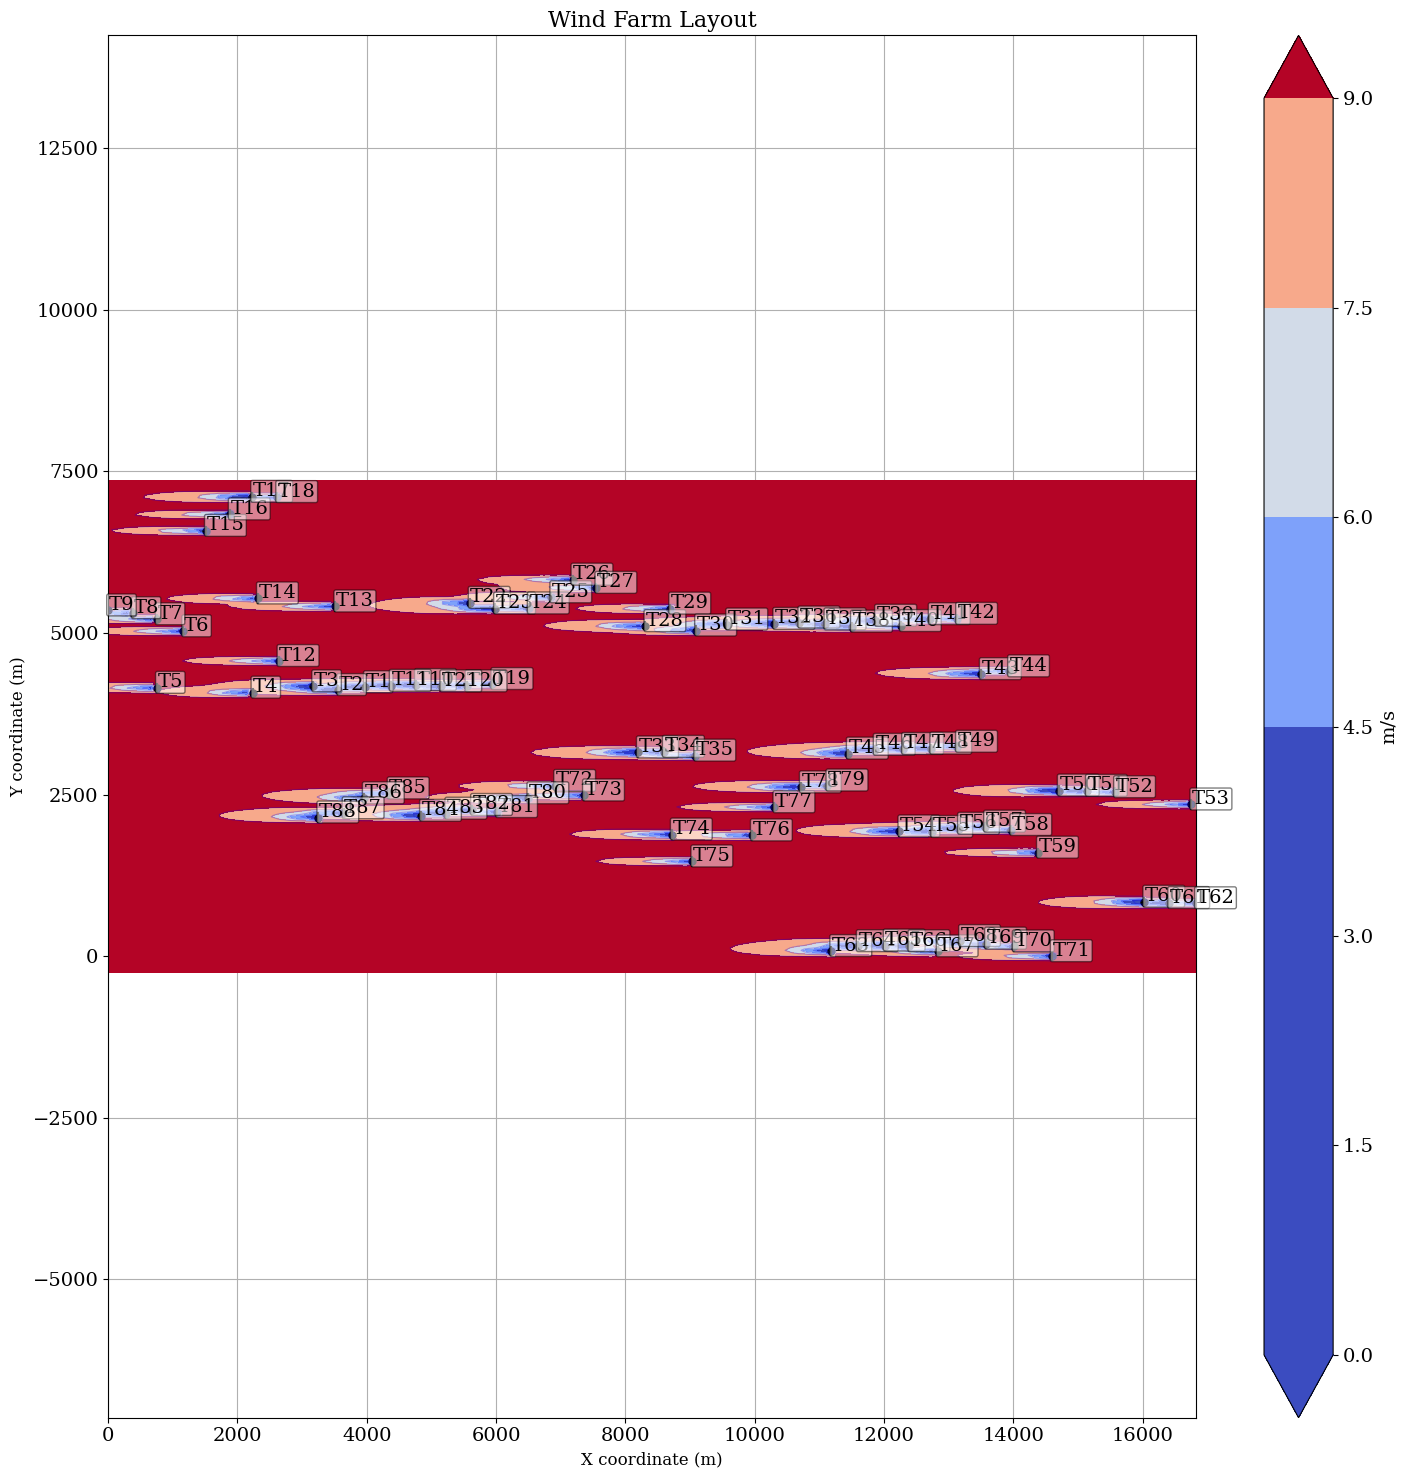

In [11]:
data_inspector.plot_wind_farm()

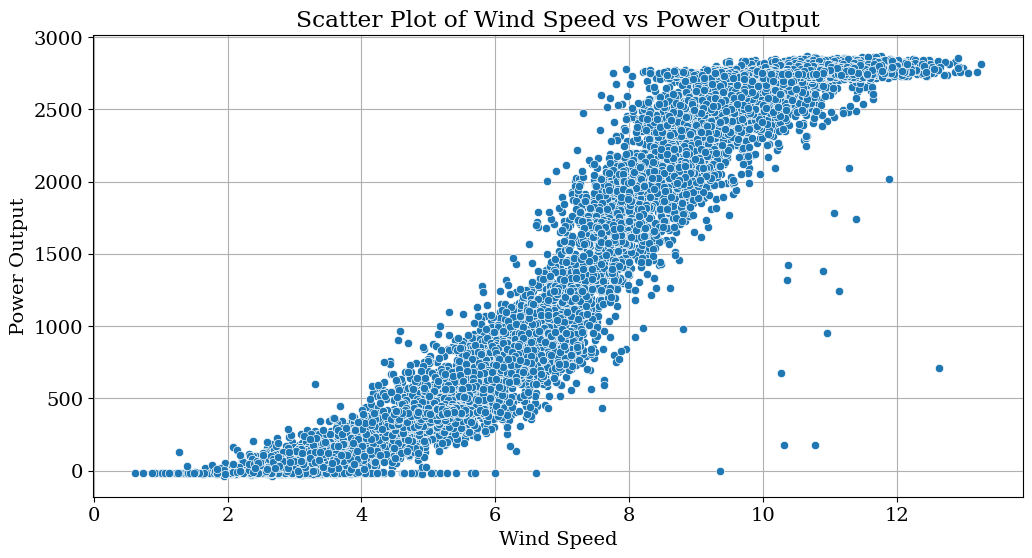

In [12]:
data_inspector.plot_wind_speed_power(df, turbine_ids=["wt073"])

  r = _zeros._bisect(f, a, b, xtol, rtol, maxiter, args, full_output, disp)



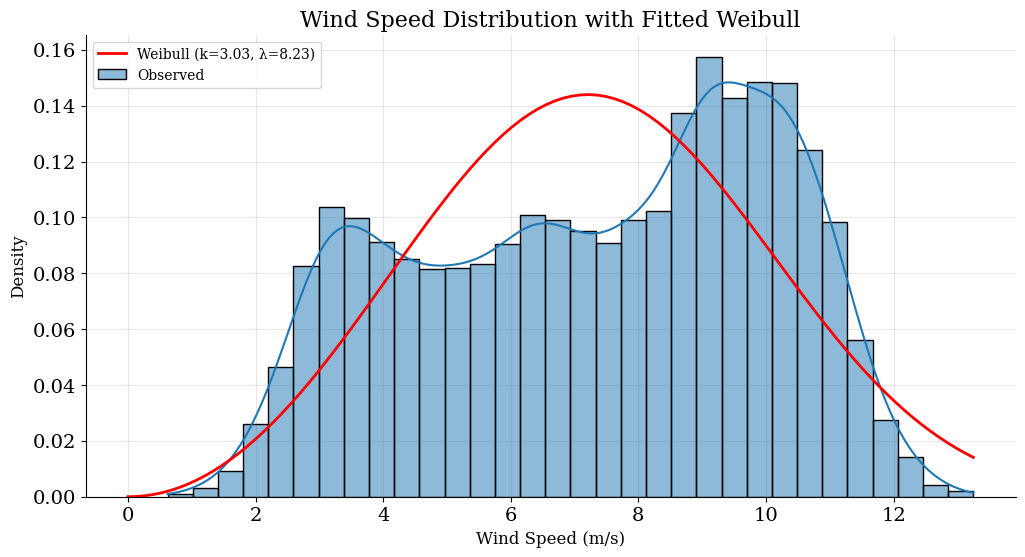

Weibull shape parameter (k): 3.03
Weibull scale parameter (λ): 8.23


In [13]:
data_inspector.plot_wind_speed_weibull(df, turbine_ids=["wt073"])

<Figure size 1000x1000 with 0 Axes>

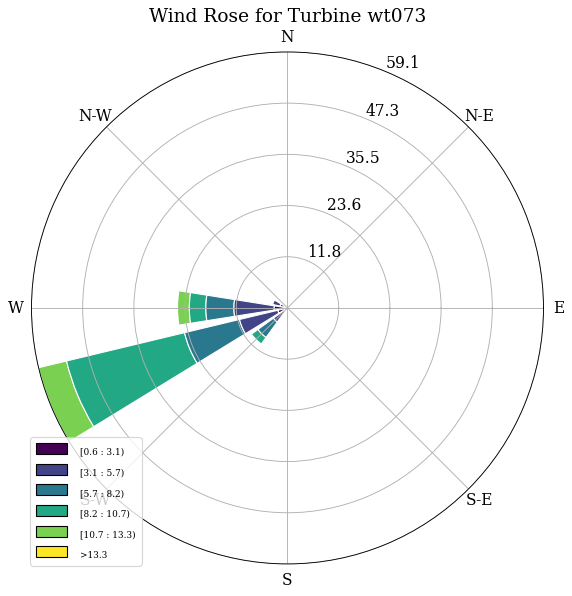

In [14]:
data_inspector.plot_wind_rose(df, turbine_ids=["wt073"])

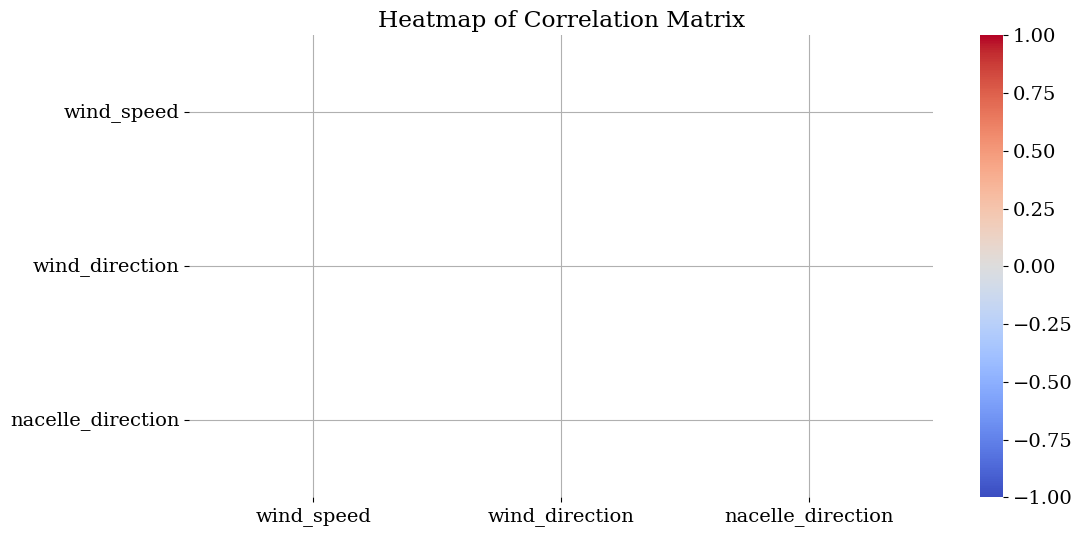

In [15]:
data_inspector.plot_correlation(df, ["wind_speed", "wind_direction", "nacelle_direction"])

In [16]:
data_inspector.plot_boxplot_wind_speed_direction(df, turbine_ids=["wt073"])

TypeError: DataInspector.plot_boxplot_wind_speed_direction() got multiple values for argument 'turbine_ids'

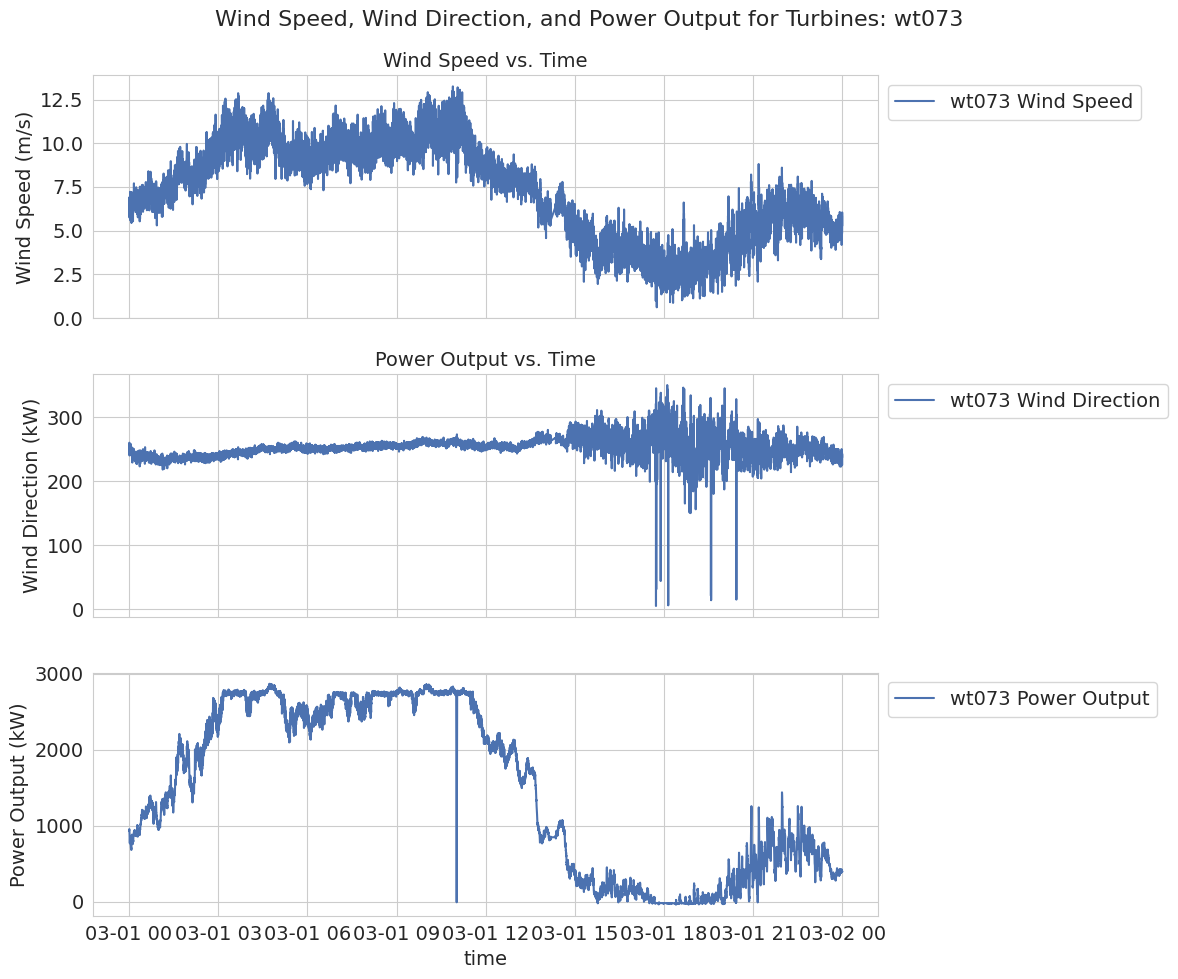

In [18]:
# from types import MethodType
# data_inspector.plot_time_series = MethodType(plot_time_series, data_inspector)
data_inspector.plot_time_series(df, turbine_ids=["wt073"])

## OpenOA Data Preparation & Inspection

In [19]:
print(f"Features of interest = {data_loader.features}")
print(f"Available features = {df.columns}")
desc_df = qa.describe(df.to_pandas())
desc_df.loc[desc_df.index.isin(data_loader.features)]

Features of interest = ['turbine_id', 'time', 'turbine_status', 'wind_direction', 'wind_speed', 'power_output', 'nacelle_direction']
Available features = ['turbine_id', 'time', 'turbine_status', 'wind_direction', 'wind_speed', 'power_output', 'nacelle_direction']


count                        mean                  min  \
time                 1488372  2022-03-01 12:00:55.673000  2022-03-01 00:00:00   
turbine_status       11828.0                         1.0                  1.0   
wind_direction     1349604.0                  224.996683                  0.0   
wind_speed         1211033.0                    7.554718                  0.0   
power_output       1209591.0                 1441.279001           -53.414284   
nacelle_direction    70126.0                    229.3015                  0.0   

                                   25%                  50%  \
time               2022-03-01 05:58:45  2022-03-01 11:58:30   
turbine_status                     1.0                  1.0   
wind_direction                   213.0                223.0   
wind_speed                    4.687309             7.583966   
power_output                247.686554            1359.8479   
nacelle_direction                218.0                226.0   

                                   75%                  max       std  
time               2022-03-01 18:04:40  2022-03-02 00:00:00       NaN  
turbine_status                     1.0                  1.0       0.0  
wind_direction                   233.0                359.0  24.22461  
wind_speed                   10.291321             22.18991  3.281106  
power_output               2730.861815           2945.00928  1143.728  
nacelle_direction                237.0                359.0  24.42134

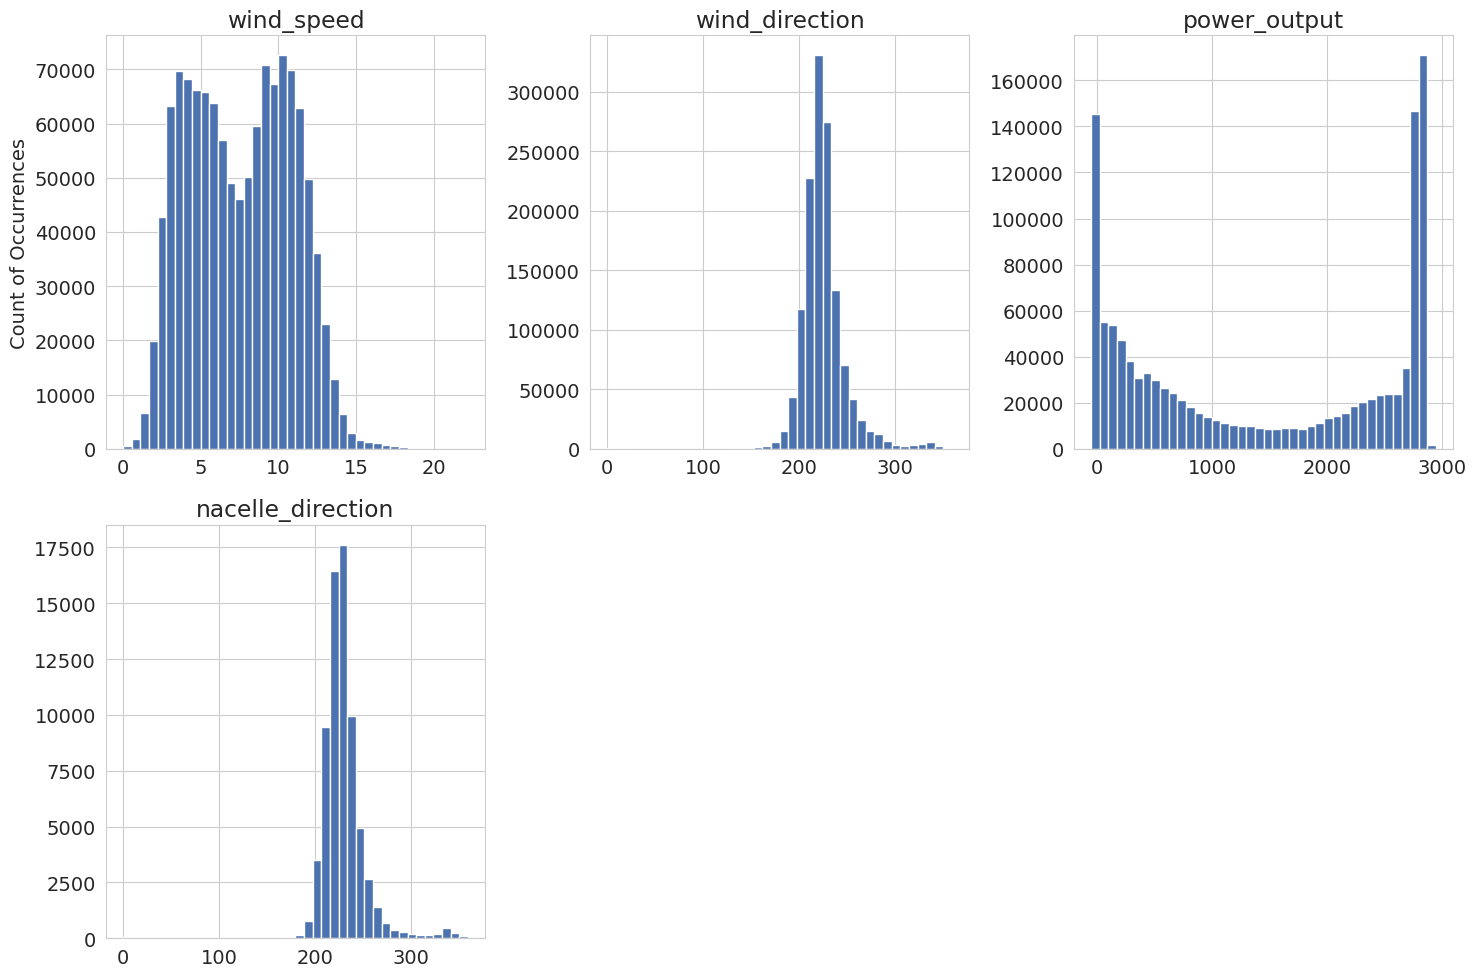

In [20]:
plot.column_histograms(df.select(["wind_speed", "wind_direction", "power_output", "nacelle_direction"]).select(cs.numeric()).to_pandas())

## OpenOA Filtering

### Unresponsive Sensor Filter

In [23]:
ws = df["wind_speed"].to_pandas()
wd = df["wind_direction"].to_pandas()
pwr = df["power_output"].to_pandas()

ws_frozen_sensor = filters.unresponsive_flag(data=ws, threshold=3)
wd_frozen_sensor = filters.unresponsive_flag(data=wd, threshold=3)
pwr_frozen_sensor = filters.unresponsive_flag(data=pwr, threshold=3)
qa.describe(pl.concat([df.select(["wind_speed"]).filter(pl.Series(ws_frozen_sensor)),
                      df.select(["wind_direction"]).filter(pl.Series(wd_frozen_sensor)),
                      df.select(["power_output"]).filter(pl.Series(pwr_frozen_sensor))], how="horizontal").to_pandas())

count       mean        std  min  25%  50%   75%   max
wind_speed        0.0        NaN        NaN  NaN  NaN  NaN   NaN   NaN
wind_direction  105.0  14.733333  20.341917  1.0  2.0  9.0  12.0  90.0
power_output      0.0        NaN        NaN  NaN  NaN  NaN   NaN   NaN

  fig.tight_layout()



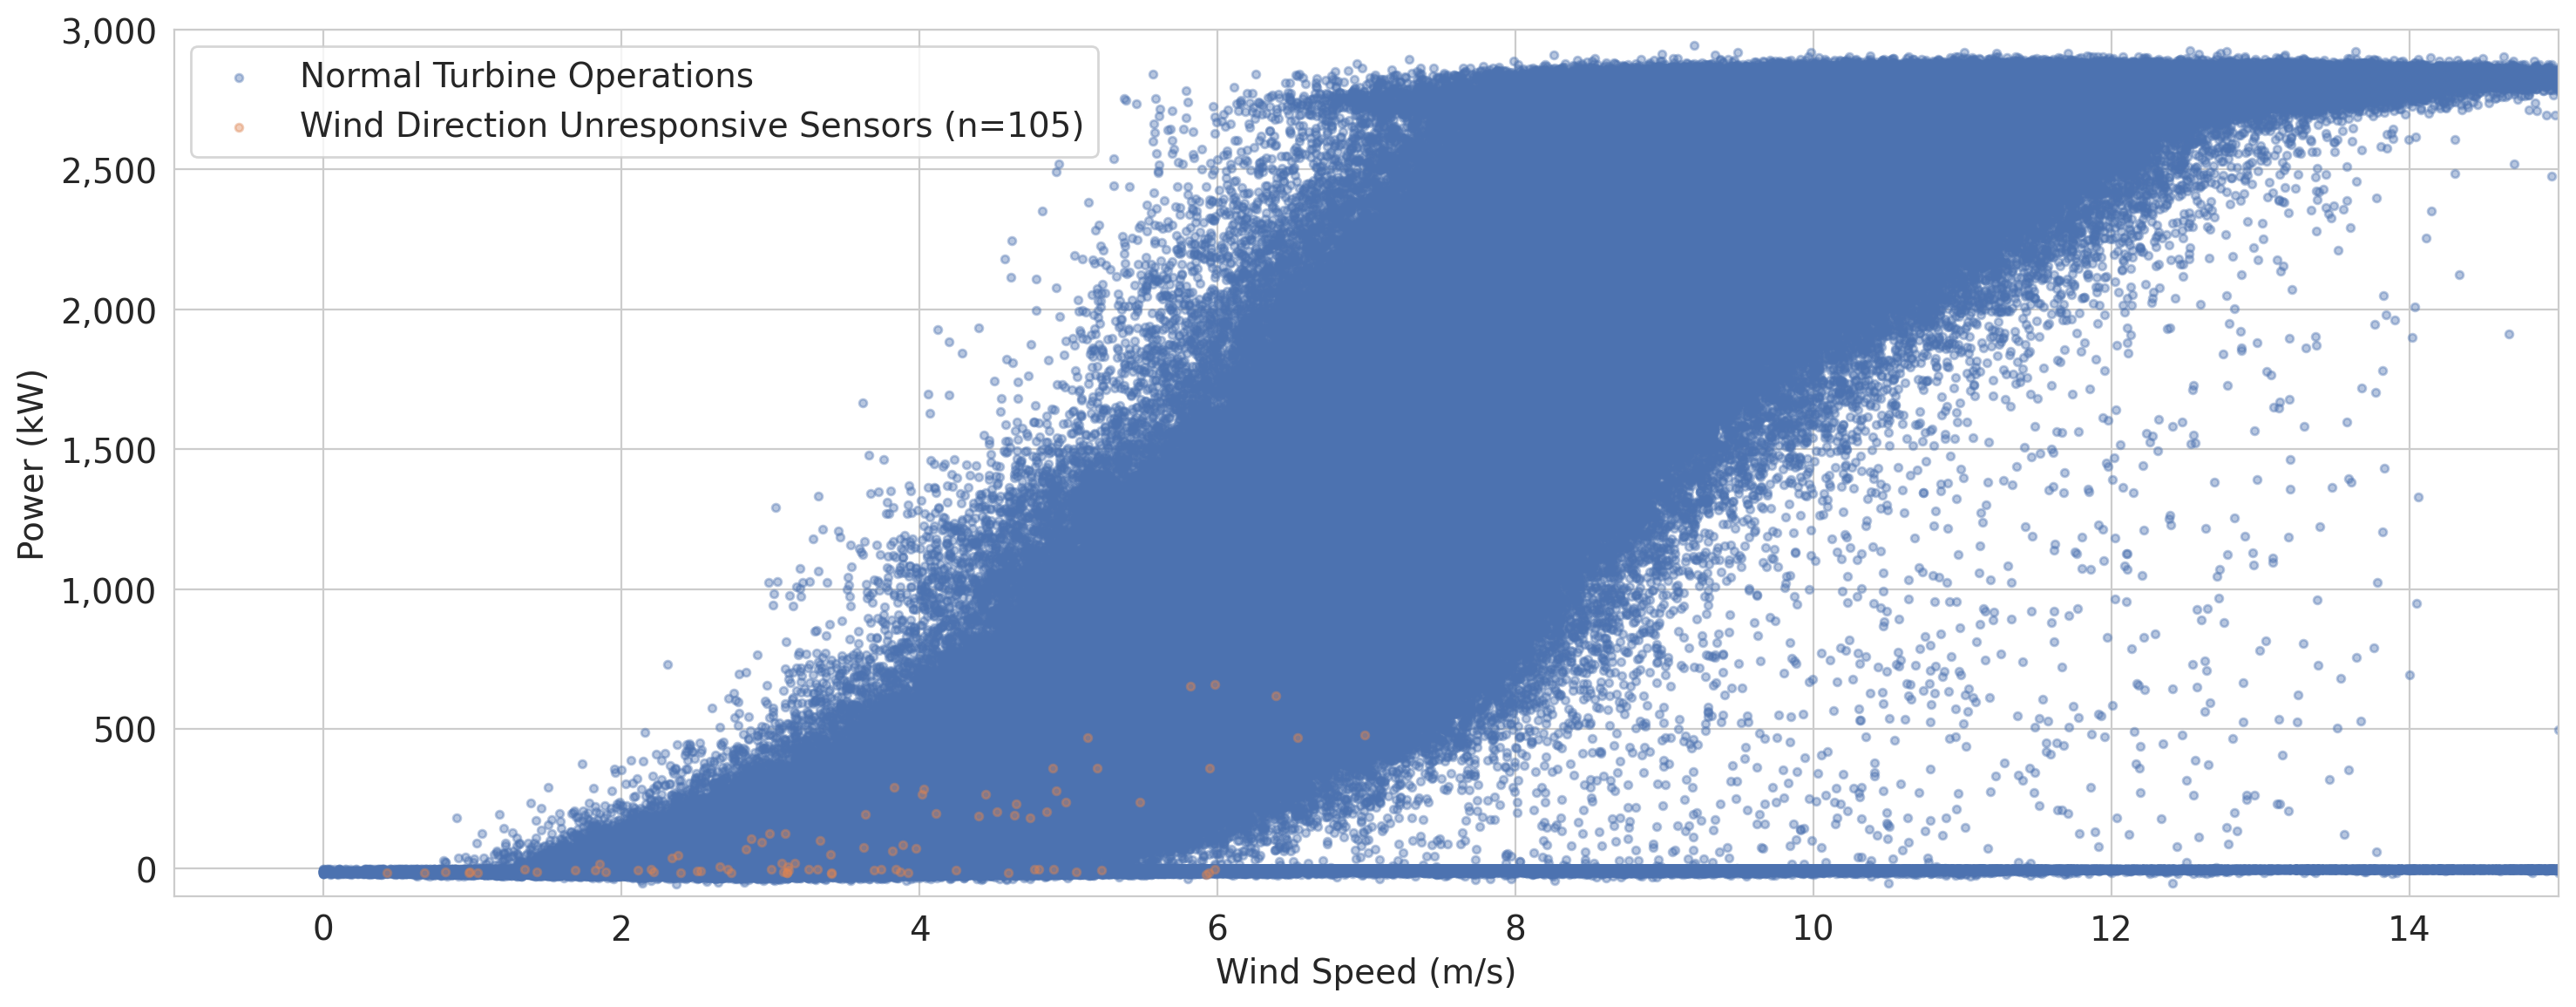

In [24]:
plot.plot_power_curve(
    ws,
    pwr,
    flag=ws_frozen_sensor,
    flag_labels=(f"Wind Speed Unresponsive Sensors (n={ws_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
    xlim=(-1, 15),  # optional input for refining plots
    ylim=(-100, 3000),  # optional input for refining plots
    legend=True,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
)

# plot.plot_power_curve(
#     ws,
#     pwr,
#     flag=wd_frozen_sensor,
#     flag_labels=(f"Wind Direction Unresponsive Sensors (n={wd_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
#     xlim=(-1, 15),  # optional input for refining plots
#     ylim=(-100, 3000),  # optional input for refining plots
#     legend=True,  # optional flag for adding a legend
#     scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
# )

# plot.plot_power_curve(
#     ws,
#     pwr,
#     flag=pwr_frozen_sensor,
#     flag_labels=(f"Power Output Unresponsive Sensors (n={pwr_frozen_sensor.sum():,.0f})", "Normal Turbine Operations"),
#     xlim=(-1, 15),  # optional input for refining plots
#     ylim=(-100, 3000),  # optional input for refining plots
#     legend=True,  # optional flag for adding a legend
#     scatter_kwargs=dict(alpha=0.4, s=10)  # optional input for refining plots
# )

In [ ]:
# change the values corresponding to frozen sensor measurements to null or interpolate (instead of dropping full row, since other sensors could be functioning properly)
# df = df.with_columns([pl.when(ws_frozen_sensor).then(None).otherwise(pl.col("wind_speed")).alias("wind_speed"), 
#                 pl.when(wd_frozen_sensor).then(None).otherwise(pl.col("wind_direction")).alias("wind_direction"),
#                 pl.when(pwr_frozen_sensor).then(None).otherwise(pl.col("power_output")).alias("power_output")
#                 ])
df = df.with_columns(
                pl.when(~ws_frozen_sensor).then(pl.col("wind_speed")).alias("wind_speed"), 
                # pl.when(~wd_frozen_sensor).then(pl.col("wind_direction")).alias("wind_direction")
                # pl.when(~pwr_frozen_sensor).then(pl.col("power_output").alias("power_output")
                )

In [25]:
df = data_filter.resolve_missing_data(df, features=["wind_speed", "wind_direction", "power_output"], how="forward_fill")
df

shape: (1_488_372, 7)
┌────────────┬──────────────┬──────────────┬──────────────┬────────────┬─────────────┬─────────────┐
│ turbine_id ┆ time         ┆ turbine_stat ┆ wind_directi ┆ wind_speed ┆ power_outpu ┆ nacelle_dir │
│ ---        ┆ ---          ┆ us           ┆ on           ┆ ---        ┆ t           ┆ ection      │
│ str        ┆ datetime[ms] ┆ ---          ┆ ---          ┆ f64        ┆ ---         ┆ ---         │
│            ┆              ┆ f64          ┆ f64          ┆            ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪══════════════╪════════════╪═════════════╪═════════════╡
│ wt001      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 6.137497   ┆ 990.080261  ┆ null        │
│            ┆ 00:00:00     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 220.0        ┆ 6.739313   ┆ 998.767334  ┆ null        │
│            ┆ 00:00:05     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 210.0        ┆ 6.739313   ┆ 998.767334  ┆ null        │
│            ┆ 00:00:10     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 214.0        ┆ 7.301422   ┆ 989.993958  ┆ null        │
│            ┆ 00:00:15     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 219.0        ┆ 6.638575   ┆ 999.7942    ┆ null        │
│            ┆ 00:00:20     ┆              ┆              ┆            ┆             ┆             │
│ …          ┆ …            ┆ …            ┆ …            ┆ …          ┆ …           ┆ …           │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 194.0        ┆ 5.239842   ┆ 402.2117    ┆ null        │
│            ┆ 23:59:40     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 199.0        ┆ 5.239842   ┆ 402.2117    ┆ null        │
│            ┆ 23:59:45     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 200.0        ┆ 5.675796   ┆ 403.063629  ┆ null        │
│            ┆ 23:59:50     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 195.0        ┆ 5.294231   ┆ 381.0566    ┆ null        │
│            ┆ 23:59:55     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-02   ┆ null         ┆ 195.0        ┆ 5.436787   ┆ 386.884247  ┆ null        │
│            ┆ 00:00:00     ┆              ┆              ┆            ┆             ┆             │
└────────────┴──────────────┴──────────────┴──────────────┴────────────┴─────────────┴─────────────┘

### Wind Speed Range Filter

In [26]:
# TODO nacelle calibration

# check for wind speed values that are outside of the acceptable range
out_of_range = filters.range_flag(df["wind_speed"].to_pandas(), lower=0, upper=70)
out_of_range &= ~df["wind_speed"].to_pandas().isna()
df["wind_speed"].filter(pl.Series(out_of_range))

shape: (0,)
Series: 'wind_speed' [f64]
[
]

### Power Curve Window Range Filter

In [27]:
# apply a window range filter to remove data with power values outside of the window from 20 to 2100 kW for wind speeds between 5 and 40 m/s.
out_of_window = filters.window_range_flag(window_col=df["wind_speed"].to_pandas(), window_start=5., window_end=40., 
                                          value_col=df["power_output"].to_pandas(), value_min=20., value_max=3000.)
df.select(["wind_speed", "power_output"]).filter(pl.Series(out_of_window))

shape: (38_716, 2)
┌────────────┬──────────────┐
│ wind_speed ┆ power_output │
│ ---        ┆ ---          │
│ f64        ┆ f64          │
╞════════════╪══════════════╡
│ 9.68657    ┆ -11.246446   │
│ 9.68657    ┆ -11.246446   │
│ 5.358623   ┆ -14.34586    │
│ 5.3942     ┆ -14.13747    │
│ 5.308838   ┆ -13.793973   │
│ …          ┆ …            │
│ 8.456439   ┆ -12.587465   │
│ 9.315008   ┆ 2.156548     │
│ 5.332747   ┆ -17.24587    │
│ 5.472084   ┆ -18.26103    │
│ 5.157559   ┆ -0.304641    │
└────────────┴──────────────┘

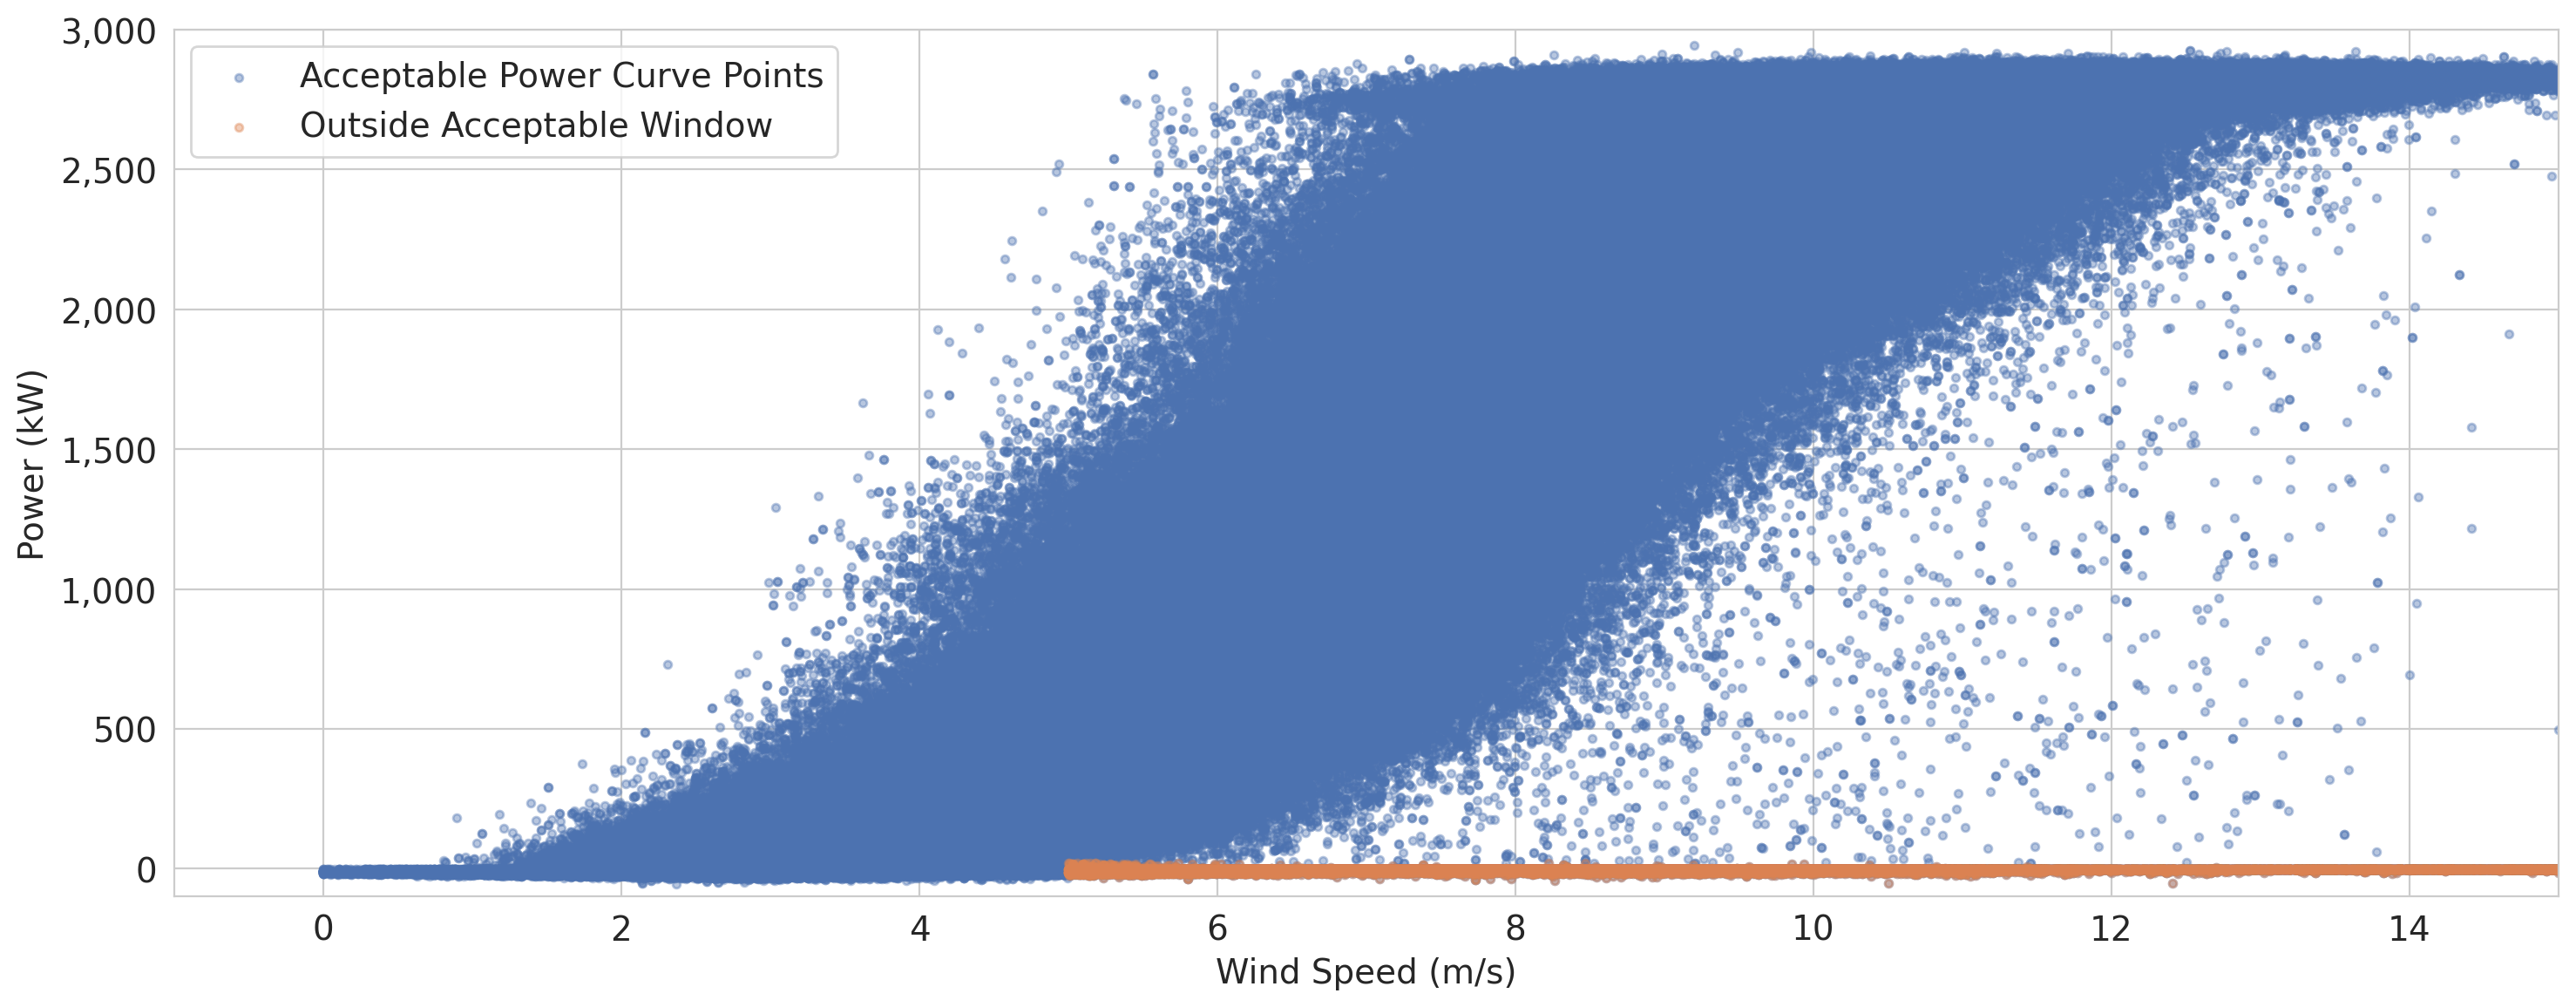

In [28]:
# plot values that are outside of power-wind speed range
plot.plot_power_curve(
    df["wind_speed"].to_pandas(),
    df["power_output"].to_pandas(),
    flag=out_of_window,
    flag_labels=("Outside Acceptable Window", "Acceptable Power Curve Points"),
    xlim=(-1, 15),
    ylim=(-100, 3000),
    legend=True,
    scatter_kwargs=dict(alpha=0.4, s=10)
)

In [29]:
# remove rows corresponding to values that are outside of power-wind speed window range
df = df.filter(pl.Series(~out_of_window))
df

shape: (1_449_656, 7)
┌────────────┬──────────────┬──────────────┬──────────────┬────────────┬─────────────┬─────────────┐
│ turbine_id ┆ time         ┆ turbine_stat ┆ wind_directi ┆ wind_speed ┆ power_outpu ┆ nacelle_dir │
│ ---        ┆ ---          ┆ us           ┆ on           ┆ ---        ┆ t           ┆ ection      │
│ str        ┆ datetime[ms] ┆ ---          ┆ ---          ┆ f64        ┆ ---         ┆ ---         │
│            ┆              ┆ f64          ┆ f64          ┆            ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪══════════════╪════════════╪═════════════╪═════════════╡
│ wt001      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 6.137497   ┆ 990.080261  ┆ null        │
│            ┆ 00:00:00     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 220.0        ┆ 6.739313   ┆ 998.767334  ┆ null        │
│            ┆ 00:00:05     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 210.0        ┆ 6.739313   ┆ 998.767334  ┆ null        │
│            ┆ 00:00:10     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 214.0        ┆ 7.301422   ┆ 989.993958  ┆ null        │
│            ┆ 00:00:15     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 219.0        ┆ 6.638575   ┆ 999.7942    ┆ null        │
│            ┆ 00:00:20     ┆              ┆              ┆            ┆             ┆             │
│ …          ┆ …            ┆ …            ┆ …            ┆ …          ┆ …           ┆ …           │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 194.0        ┆ 5.239842   ┆ 402.2117    ┆ null        │
│            ┆ 23:59:40     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 199.0        ┆ 5.239842   ┆ 402.2117    ┆ null        │
│            ┆ 23:59:45     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 200.0        ┆ 5.675796   ┆ 403.063629  ┆ null        │
│            ┆ 23:59:50     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 195.0        ┆ 5.294231   ┆ 381.0566    ┆ null        │
│            ┆ 23:59:55     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-02   ┆ null         ┆ 195.0        ┆ 5.436787   ┆ 386.884247  ┆ null        │
│            ┆ 00:00:00     ┆              ┆              ┆            ┆             ┆             │
└────────────┴──────────────┴──────────────┴──────────────┴────────────┴─────────────┴─────────────┘

### Power Curve Bin Filter

In [40]:
# apply a bin filter to remove data with power values outside of an envelope around median power curve at each wind speed
pwr = df["power_output"].to_pandas()
ws = df["wind_speed"].to_pandas()
max_bin = 0.90 * df["power_output"].max()
bin_outliers = filters.bin_filter(bin_col=pwr, 
                                  value_col=ws, 
                                  bin_width=50, threshold=3,
                                  center_type="median", 
                                  bin_min=20., bin_max=max_bin,
                                  threshold_type="scalar", direction="below",
                                  )
qa.describe(df.select(["wind_speed", "power_output"]).filter(pl.Series(bin_outliers)).to_pandas())

count         mean         std         min          25%  \
wind_speed    707.0     5.242669    1.062435    0.896955     4.570433   
power_output  707.0  1993.172081  545.437561  182.950943  1561.687380   

                      50%          75%          max  
wind_speed       5.525102     6.061896     6.844024  
power_output  2170.569820  2433.681275  2649.223390

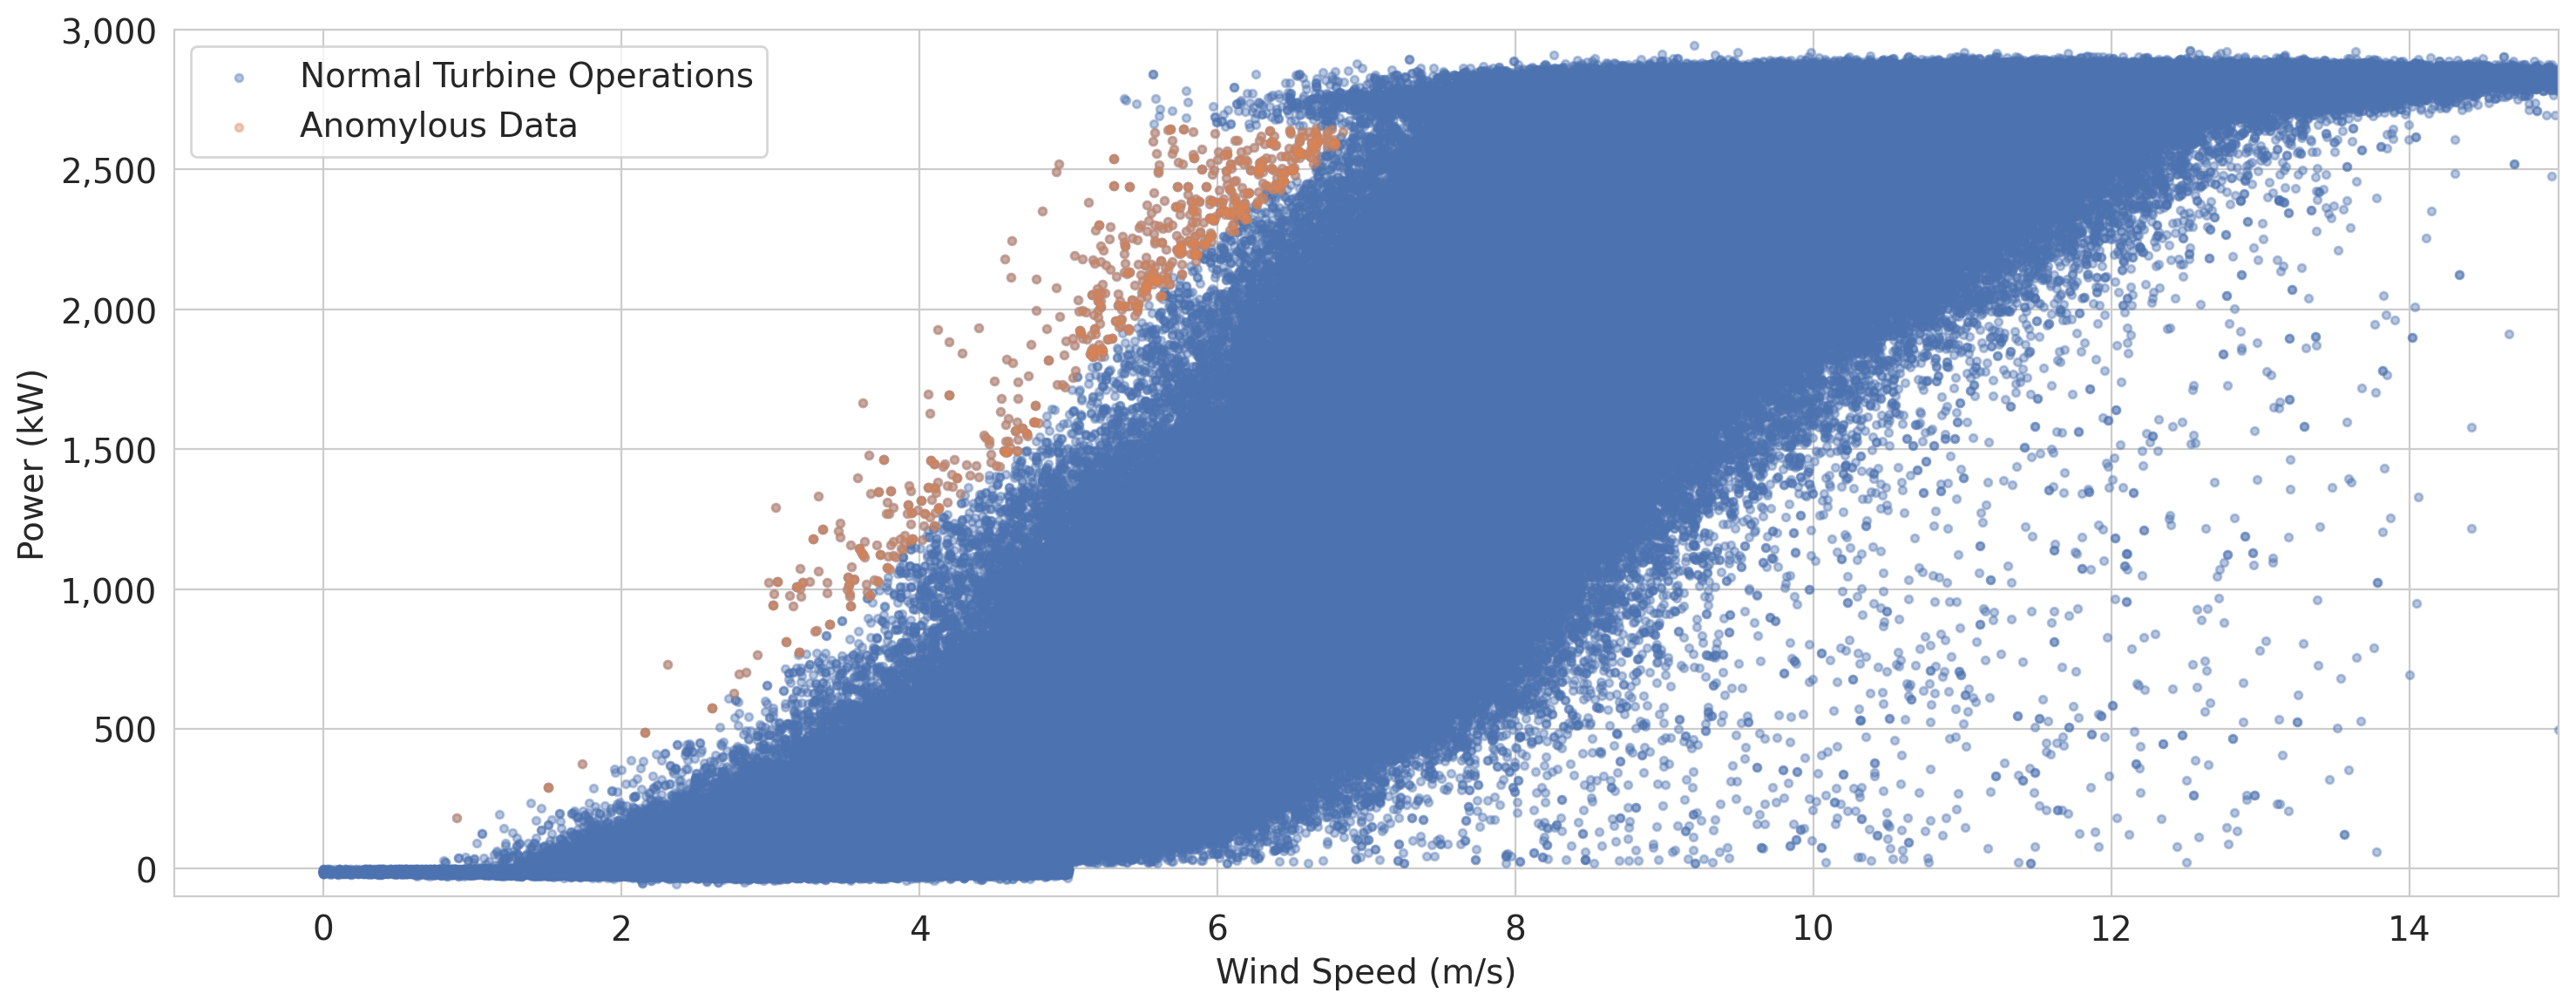

In [41]:
# plot values outside the power-wind speed bin filter
plot.plot_power_curve(
    ws,
    pwr,
    flag=bin_outliers,
    flag_labels=("Anomylous Data", "Normal Wind Speed Sensor Operation"),
    xlim=(-1, 15),
    ylim=(-100, 3000),
    legend=True,
    scatter_kwargs=dict(alpha=0.4, s=10)
)

In [42]:
# remove rows corresponding to values that are outside of power-wind speed bins 
df = df.filter(pl.Series(~bin_outliers))
df

shape: (1_448_949, 7)
┌────────────┬──────────────┬──────────────┬──────────────┬────────────┬─────────────┬─────────────┐
│ turbine_id ┆ time         ┆ turbine_stat ┆ wind_directi ┆ wind_speed ┆ power_outpu ┆ nacelle_dir │
│ ---        ┆ ---          ┆ us           ┆ on           ┆ ---        ┆ t           ┆ ection      │
│ str        ┆ datetime[ms] ┆ ---          ┆ ---          ┆ f64        ┆ ---         ┆ ---         │
│            ┆              ┆ f64          ┆ f64          ┆            ┆ f64         ┆ f64         │
╞════════════╪══════════════╪══════════════╪══════════════╪════════════╪═════════════╪═════════════╡
│ wt001      ┆ 2022-03-01   ┆ null         ┆ null         ┆ 6.137497   ┆ 990.080261  ┆ null        │
│            ┆ 00:00:00     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 220.0        ┆ 6.739313   ┆ 998.767334  ┆ null        │
│            ┆ 00:00:05     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 210.0        ┆ 6.739313   ┆ 998.767334  ┆ null        │
│            ┆ 00:00:10     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 214.0        ┆ 7.301422   ┆ 989.993958  ┆ null        │
│            ┆ 00:00:15     ┆              ┆              ┆            ┆             ┆             │
│ wt001      ┆ 2022-03-01   ┆ null         ┆ 219.0        ┆ 6.638575   ┆ 999.7942    ┆ null        │
│            ┆ 00:00:20     ┆              ┆              ┆            ┆             ┆             │
│ …          ┆ …            ┆ …            ┆ …            ┆ …          ┆ …           ┆ …           │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 194.0        ┆ 5.239842   ┆ 402.2117    ┆ null        │
│            ┆ 23:59:40     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 199.0        ┆ 5.239842   ┆ 402.2117    ┆ null        │
│            ┆ 23:59:45     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 200.0        ┆ 5.675796   ┆ 403.063629  ┆ null        │
│            ┆ 23:59:50     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-01   ┆ null         ┆ 195.0        ┆ 5.294231   ┆ 381.0566    ┆ null        │
│            ┆ 23:59:55     ┆              ┆              ┆            ┆             ┆             │
│ wt088      ┆ 2022-03-02   ┆ null         ┆ 195.0        ┆ 5.436787   ┆ 386.884247  ┆ null        │
│            ┆ 00:00:00     ┆              ┆              ┆            ┆             ┆             │
└────────────┴──────────────┴──────────────┴──────────────┴────────────┴─────────────┴─────────────┘

### Power Curve Fitting

In [ ]:
# Fit the power curves
ws = df["wind_speed"].to_pandas()
pwr = df["power_output"].to_pandas()
iec_curve = power_curve.IEC(ws, pwr)
l5p_curve = power_curve.logistic_5_parametric(ws, pwr)
spline_curve = power_curve.gam(ws, pwr, n_splines=20)

  return d + (a - d) / (1 + (x / c) ** b) ** g



In [ ]:
fig, ax = plot.plot_power_curve(
    ws,
    pwr,
    flag=np.zeros(ws.shape, dtype=bool),
    flag_labels=("", "Filtered Power Curve"),
    xlim=(-1, 15),  # optional input for refining plots
    ylim=(-100, 3000),  # optional input for refining plots
    legend=False,  # optional flag for adding a legend
    scatter_kwargs=dict(alpha=0.4, s=10),  # optional input for refining plots
    return_fig=True,
)

x = np.linspace(0, 20, 100)
ax.plot(x, iec_curve(x), color="red", label = "IEC", linewidth = 3)
ax.plot(x, spline_curve(x), color="C1", label = "Spline", linewidth = 3)
ax.plot(x, l5p_curve(x), color="C2", label = "L5P", linewidth = 3)

ax.legend()

fig.tight_layout()
plt.show()